In [1]:
from numba import njit, jit, types, typed
import pandas as pd
import numpy as np
# from typing import Tuple

from numba.typed import Dict

import sys
sys.path.insert(0, './hftbacktest')  # Add the utils folder to the system path

from hftbacktest import NONE, NEW, HftBacktest, GTX, FeedLatency, BUY, SELL, Linear, Stat



In [2]:
# Support And Resistance

@njit
def leftLimitExtract(bids,leftLimit):
  res = []
  for x in bids:
    # num1 = float(x)
    num1 = x
    if num1<leftLimit:
      break
    # num2 = float(bids[x])
    num2 = bids[x]
    res.append([num1,num2])
  return res

@njit
def rightLimitExtract(asks,rightLimit):
  res = []
  for x in asks:
    # num1 = float(x)
    num1 = x
    if num1 > rightLimit:
      break
    # num2 = float(asks[x])
    num2 = asks[x]
    res.append([num1,num2])
  return res

@njit
def limitExtractDepth(bids,asks,limitPercent):
  currPrice = float(next(iter(bids)))
  leftLimit = currPrice - (currPrice*limitPercent)
  rightLimit = currPrice + (currPrice*limitPercent)

  bids = leftLimitExtract(bids,leftLimit)
  asks = rightLimitExtract(asks,rightLimit)
  return bids,asks

@njit
def parseToBarData(data, binNum=50):
  # print(data)
  arr = np.array(data)
  x,y = np.histogram(arr[:,0],weights=arr[:,1], bins = binNum)
  y = [(y[i]+y[i-1])/2 for i in range(1,len(y))]
  return np.column_stack((y,x)).tolist()
# return 



@njit
def getSupportResistance(bids, asks, limitPercent):
    
  binNum = 50
  
  # Compute support
  arr = np.array(bids)
  x = np.zeros(binNum)
  y = np.zeros(binNum)

  # Calculate the bin size
  bin_size = (arr[:,0].max() - arr[:,0].min()) / binNum

  # Calculate the weighted histogram
  for i in range(len(arr)):
    idx = int((arr[i, 0] - arr[:,0].min()) / bin_size)
    if idx == binNum:
      idx -= 1
    x[idx] += arr[i, 1]
    y[idx] += 1

  # Calculate the bin centers
  for i in range(1, len(y)):
    y[i-1] = (y[i-1] + y[i]) / 2
  y = y[:-1]

  support = typed.List()
  for i in range(len(y)):
    support.append([y[i], x[i]])

  # Compute resistance
  arr = np.array(asks)
  x = np.zeros(binNum)
  y = np.zeros(binNum)

  # Calculate the bin size
  bin_size = (arr[:,0].max() - arr[:,0].min()) / binNum

  # Calculate the weighted histogram
  for i in range(len(arr)):
    idx = int((arr[i, 0] - arr[:,0].min()) / bin_size)
    if idx == binNum:
      idx -= 1
    x[idx] += arr[i, 1]
    y[idx] += 1

  # Calculate the bin centers
  for i in range(1, len(y)):
    y[i-1] = (y[i-1] + y[i]) / 2
  y = y[:-1]

  resistance = typed.List()
  for i in range(len(y)):
    resistance.append([y[i], x[i]])
    
  # Sort by descending order of weights
  support.sort(reverse=True, key=lambda x: x[1])
  resistance.sort(reverse=True, key=lambda x: x[1])

  

  return resistance,support



In [3]:

@njit
def testHFT(hbt, stat):
    # print(hbt.best_bid)
    # print(len(hbt.bid))
    limitPercent = 0.05
    bid,ask = limitExtractDepth(hbt.bid,hbt.ask,limitPercent ) 
    print(bid)
    supportLevel, resistanceLevel = getSupportResistance(bid, ask, limitPercent)
    print(len(supportLevel))
    print(len(resistanceLevel))
    # bid = {str(k): str(v) for k, v in hbt.bid.items()}
    # ask = {str(k): str(v) for k, v in hbt.ask.items()}
    # bid,ask = limitExtractDepth(hbt.bid,hbt.ask,0.05 )
    # resistance, support = getSupportResistance(bid, ask, 0.05)
    # print("start resistance")
    # print(resistance)
    # print("end resistance")
    # print(hbt.ask)
@njit
def gridtrading(hbt, stat):
    while hbt.run:
        # Running interval in microseconds
        if not hbt.elapse(0.1 * 1e6):
            return False
        # Clear cancelled, filled or expired orders.
        hbt.clear_inactive_orders()
        
        # bids = hbt.bid
        # asks = hbt.ask

        # This is an example to show how to use hftbacktest.
        # The stat varies a lot according to the configuration and the market condition.
        max_position = 5
        order_interval = hbt.tick_size * 10

        grid_num = 20
        half_spread = hbt.tick_size * 20
        
        mid_price = (hbt.best_bid + hbt.best_ask) / 2.0
        # Round price
        bid_order_begin = np.floor((mid_price - half_spread) / order_interval) * order_interval
        ask_order_begin = np.ceil((mid_price + half_spread) / order_interval) * order_interval
        
        
        # # Limit support/resistance in grid range        
        # bid = {str(k): str(v) for k, v in hbt.bid.items()}
        # ask = {str(k): str(v) for k, v in hbt.ask.items()}
        # limitPercent = (ask_order_begin + grid_num * order_interval) / mid_price - 1
        
        
        limitPercent = 0.05
        bid,ask = limitExtractDepth(hbt.bid,hbt.ask,limitPercent )        
        supportLevel, resistanceLevel = getSupportResistance(bid, ask, limitPercent)      

        
       
        
        order_qty = 0.1 # np.round(notional_order_qty / mid_price / hbt.lot_size) * hbt.lot_size
        last_order_id = -1
        
        # Create a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position: # hbt.position * mid_price < max_notional_position
            p = hbt.position
            
            ## Support 
            
            for bid in supportLevel:                
                bid_order_begin = bid[0] # supportLevel = [[0.01254, 11310.9], [0.0125, 3453.6]....]
                bid_order_tick = round(bid_order_begin / hbt.tick_size)
                # Do not post buy orders above the best bid and below grid range.
                if bid_order_tick > hbt.best_bid_tick or bid[0] < bid_order_begin - grid_num * order_interval:
                    continue
                p += order_qty
                # Do not post buy orders that can exceed the maximum position.
                if p >= max_position:
                    continue
                # order price in tick is used as order id.
                new_bid_orders[bid_order_tick] = bid_order_begin
            
            for i in range(grid_num):
                bid_order_begin -= i * order_interval
                bid_order_tick = round(bid_order_begin / hbt.tick_size)
                # Do not post buy orders above the best bid.
                if bid_order_tick > hbt.best_bid_tick:
                    continue
                p += order_qty
                # Do not post buy orders that can exceed the maximum position.
                if p >= max_position:
                    continue
                # order price in tick is used as order id.
                
                new_bid_orders[bid_order_tick] = bid_order_begin
                # print(bid_order_tick)
                # print('\n')
                # print(bid_order_begin)
        for order in hbt.orders.values():
            # Cancel if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
                last_order_id = order.order_id
        for order_id, order_price in new_bid_orders.items():
            # Post an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
                last_order_id = order_id
        
        # Create a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position: # hbt.position * mid_price > -max_notional_position
            p = hbt.position
            
            ## RESISTANCE 
            for ask in resistanceLevel:                
                ask_order_begin = ask[0] # resistanceLevel = [[0.01254, 11310.9], [0.0125, 3453.6]....]
                # print(ask_order_begin)
                ask_order_tick = round(ask_order_begin / hbt.tick_size)
                # print(ask_order_tick)
                # Do not post sell orders below the best ask and above grid range
                if ask_order_tick < hbt.best_ask_tick or ask[0] > ask_order_begin + grid_num * order_interval:
                    continue
                p += order_qty
                # Do not post buy orders that can exceed the maximum position.
                if p <= -max_position:
                    continue
                # order price in tick is used as order id.
                new_ask_orders[ask_order_tick] = ask_order_begin
                

                
            for i in range(grid_num):
                ask_order_begin += i * order_interval
                ask_order_tick = round(ask_order_begin / hbt.tick_size)
                # Do not post sell orders below the best ask.
                if ask_order_tick < hbt.best_ask_tick:
                    continue
                p += order_qty
                # Do not post sell orders that can exceed the maximum position.
                if p <= -max_position:
                    continue
                # order price in tick is used as order id.
                new_ask_orders[ask_order_tick] = ask_order_begin
        for order in hbt.orders.values():
            # Cancel if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
                last_order_id = order.order_id
        for order_id, order_price in new_ask_orders.items():
            # Post an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
                last_order_id = order_id
        
        # Elapse a process time
        if not hbt.elapse(.05 * 1e6):
            return False
        
        # All order requests are considered to be requested at the same time.
        # Wait until one of the order responses is received.
        if last_order_id >= 0:
            if not hbt.wait_order_response(last_order_id):
                return False
        
        # Record the current state for stat calculation.
        stat.record(hbt)
    return True

In [4]:
# data file
# https://github.com/nkaz001/collect-binancefutures

# This backtest assumes market maker rebates.
# https://www.binance.com/en/support/announcement/5d3a662d3ace4132a95e77f6ab0f5422
# snapshot_df = pd.read_pickle('../../ethusdt_20221002.snapshot.pkl', compression='gzip')
# df1 = pd.read_pickle('../../ethusdt_20221003.pkl', compression='gzip')
# df2 = pd.read_pickle('../../ethusdt_20221004.pkl', compression='gzip')
# df3 = pd.read_pickle('../../ethusdt_20221005.pkl', compression='gzip')
# df4 = pd.read_pickle('../../ethusdt_20221006.pkl', compression='gzip')
# df5 = pd.read_pickle('../../ethusdt_20221007.pkl', compression='gzip')
snapshot_df = pd.read_pickle('../../btcusdt_20230225.snapshot.pkl', compression='gzip')
# df1 = pd.read_pickle('../../btcusdt_20230227.pkl', compression='gzip')
# df2 = pd.read_pickle('../../btcusdt_20230226.pkl', compression='gzip')
# df3 = pd.read_pickle('../../btcusdt_20230225.pkl', compression='gzip')
# df4 = pd.read_pickle('../../btcusdt_20230228.pkl', compression='gzip')
# df5 = pd.read_pickle('../../btcusdt_20230301.pkl', compression='gzip')
df6 = pd.read_pickle('../../btcusdt_20230302.pkl', compression='gzip')
df7 = pd.read_pickle('../../btcusdt_20230303.pkl', compression='gzip')
df = pd.concat([df6, df7])
hbt = HftBacktest(df,
                  tick_size=0.01,
                  lot_size=0.001,
                  maker_fee=-0.00005,
                  taker_fee=0.0007,
                  order_latency=FeedLatency(1),
                  asset_type=Linear,
                  snapshot=snapshot_df)
stat = Stat(hbt)
gridtrading(hbt, stat.recorder)
# testHFT(hbt, stat.recorder)

False

C:\Users\azureuser\QuanTrading\hft\example\hftbacktest\stat.py:88: RuntimeWarning: invalid value encountered in double_scalars
  return pnl.mean() / pnl.std() * np.sqrt(c * trading_days)
C:\Users\azureuser\QuanTrading\hft\example\hftbacktest\stat.py:97: RuntimeWarning: invalid value encountered in double_scalars
  return self.annualised_return(include_fee=include_fee) / self.maxdrawdown(include_fee=include_fee)


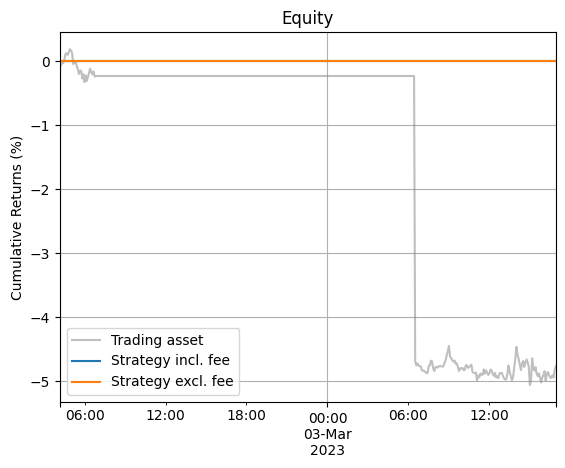

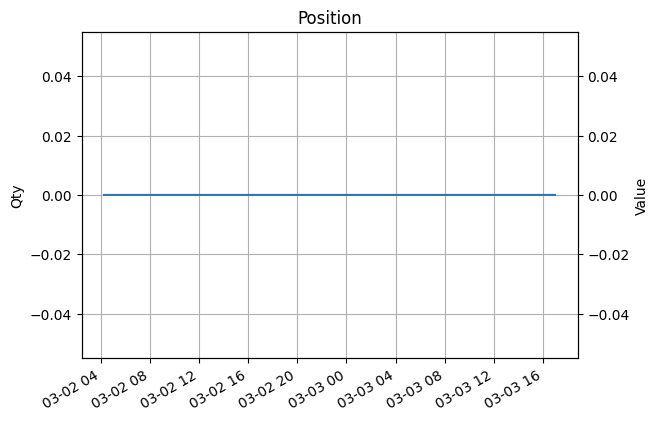

In [5]:
stat.summary(capital=2000)